<a href="https://colab.research.google.com/github/alexZajac/airlines_performance/blob/master/explanations_professors/data_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Features engineering and process

_Note: It's a notebook that can take several dozens of minutes since it explains all the features design and the optimality of code wasn't the focus here_

## Import Python libraries
---


In [ ]:
!pip install -U -r ../requirements.txt

zsh:1: command not found: pip


In [ ]:
import pandas as pd
import numpy as np
import random
from scipy.stats import pearsonr
import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta

# Graphics
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.width', 10000)

# Temp
from meteostat import Stations, Daily
from geopy.geocoders import Nominatim
from itertools import product
geolocator = Nominatim(user_agent='myapplication')

path = '../data/'

In [ ]:
# Graphical settings
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          'axes.labelsize' : 15,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.titlecolor": "black", 
          'figure.figsize': [20, 8], 
          'axes.prop_cycle': plt.cycler(color=color_list), 
          'figure.dpi' : 75, 
          'legend.fontsize': 10,
          'font.size': 15 
          }
plt.rcParams.update(params)

## Data Engineering
---

### Preprocessing

In [ ]:
# Read the CSV file, delete unnamed columns, creates load factor, keeps only number of seats > 10, creates DATE column
def read_n_clean(name):
  df = pd.read_csv(name)
  # Drop Unnamed Columns
  df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  df['DATE'] =  pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
  # We pick only data from 2013 to 2019
  date_ref1 = datetime.datetime(2013, 1, 1)
  date_ref2 = datetime.datetime(2020, 1, 1)
  df = df[(df['DATE'] >= date_ref1) & (df['DATE'] < date_ref2)]
  # We pick only flights with available seats > 10
  df = df[df["SEATS"] > 10].reset_index(drop=True)  
  # We pick only flights with non-null distance travelled 
  df = df[df["DISTANCE"] > 0].reset_index(drop=True) 
  # We dropped the Hageland Airline data -> the company has shut down since 2008 and has very low amounts of tweets
  df = df[df['UNIQUE_CARRIER'] != "H6"]
  # Load-Factor Creation
  df["RPM"] = df["PASSENGERS"] * df["DISTANCE"]
  df["ASM"] = df["SEATS"] * df["DISTANCE"]
  return df

In [ ]:
df = read_n_clean(path + "root.csv")
df.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,CARRIER_NAME,CARRIER_GROUP,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,AIRCRAFT_GROUP,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,MONTH,DISTANCE_GROUP,CLASS,DATE,RPM,ASM
0,0.0,1.0,22900.0,88.0,68.0,0.0,0.0,1149.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10423,AUS,"Austin, TX",TX,11433,DTW,"Detroit, MI",MI,6,677,1,2015,3,3,F,2015-03-01,78132.0,101112.0
1,0.0,9.0,206100.0,792.0,430.0,0.0,0.0,1042.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10423,AUS,"Austin, TX",TX,13487,MSP,"Minneapolis, MN",MN,6,677,1,2015,3,3,F,2015-03-01,448060.0,825264.0
2,0.0,1.0,22900.0,88.0,69.0,0.0,0.0,748.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10620,BIL,"Billings, MT",MT,13487,MSP,"Minneapolis, MN",MN,6,677,1,2015,3,2,F,2015-03-01,51612.0,65824.0
3,0.0,1.0,21850.0,86.0,27.0,0.0,0.0,386.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10627,BIS,"Bismarck/Mandan, ND",ND,13487,MSP,"Minneapolis, MN",MN,6,673,1,2015,3,1,F,2015-03-01,10422.0,33196.0
4,0.0,1.0,22900.0,88.0,64.0,0.0,0.0,500.0,CP,21167.0,Compass Airlines,Compass Airlines,2,11057,CLT,"Charlotte, NC",NC,11433,DTW,"Detroit, MI",MI,6,677,1,2015,3,2,F,2015-03-01,32000.0,44000.0


### Airlines Global Performance - Choosing the best relevant airlines

In [ ]:
# MOY FLIGHTS
count_flights = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PASSENGERS'].count().reset_index(name = 'NB_FLIGHTS')
count_flights_f = count_flights.groupby(['UNIQUE_CARRIER_NAME'])['NB_FLIGHTS'].mean().reset_index(name = 'MOY_NB_FLIGHTS').sort_values('MOY_NB_FLIGHTS', ascending = False)
# TOT Passengers
tot_pass = count_flights_f.merge(df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].sum().reset_index(name = 'TOT_PASS_FLIGHTS').reset_index(drop=True), on= ['UNIQUE_CARRIER_NAME']).sort_values('TOT_PASS_FLIGHTS', ascending = False)
# NB Flights
tot_nb_flights = tot_pass.merge(df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].count().reset_index(name = 'TOT_NB_FLIGHTS').reset_index(drop=True), on=['UNIQUE_CARRIER_NAME']).sort_values('TOT_NB_FLIGHTS', ascending = False)

In [ ]:
copy = tot_nb_flights.copy()
scaler = StandardScaler()
copy.iloc[:, 1:] = scaler.fit_transform(copy.iloc[:, 1:])
copy['TOTAL'] = copy['MOY_NB_FLIGHTS'] + copy['TOT_PASS_FLIGHTS'] + copy['TOT_NB_FLIGHTS']
copy.sort_values('TOTAL', ascending=False, inplace=True)
copy.head()

,UNIQUE_CARRIER_NAME,MOY_NB_FLIGHTS,TOT_PASS_FLIGHTS,TOT_NB_FLIGHTS,TOTAL
0,Southwest Airlines Co.,5.651950,7.051707,5.707278,18.410935
1,Delta Air Lines Inc.,5.269585,5.523008,5.323344,16.115938
3,United Air Lines Inc.,4.457456,3.429872,4.507881,12.395209
2,American Airlines Inc.,2.630861,4.842632,2.673787,10.147280
4,SkyWest Airlines Inc.,3.617594,1.286393,3.664571,8.568558


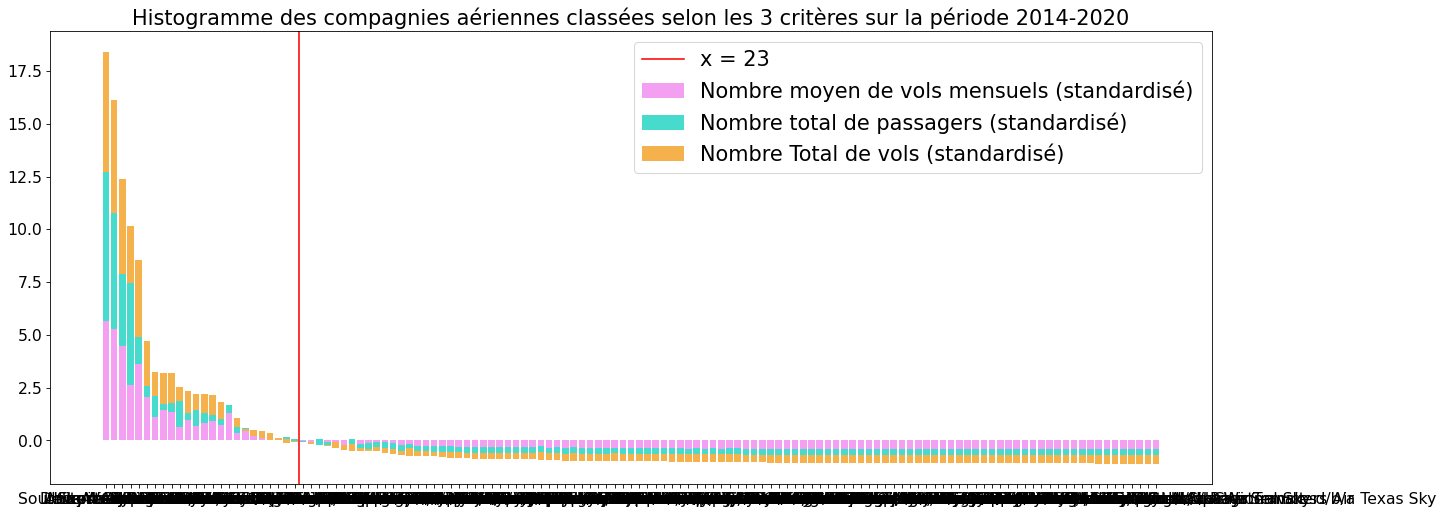

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.get_xaxis().set_visible(False)
ax.bar(copy['UNIQUE_CARRIER_NAME'], copy['MOY_NB_FLIGHTS'], color = 'C1', label = 'Standardized average number of flights per month')
ax.bar(copy['UNIQUE_CARRIER_NAME'], copy['TOT_PASS_FLIGHTS'], bottom = copy['MOY_NB_FLIGHTS'], color = 'C2', label = 'Standardized total number of passagers')
ax.bar(copy['UNIQUE_CARRIER_NAME'], copy['TOT_NB_FLIGHTS'], bottom = copy['MOY_NB_FLIGHTS'] + copy['TOT_PASS_FLIGHTS'], color = 'C3', label = 'Standardized total number of flights')
ax.axvline(x=22.5, color='r', linestyle='-', label = 'x = 23')
ax.legend(prop={'size': 15})
ax.set_title("Vertical bar plot of all the US CARRIERS sorted by their total performance on the period 2014-2019", pad = 25)
ax.patch.set_alpha(0)
fig.show()

In [ ]:
carriers_f = copy.iloc[:22, :].reset_index(drop=True)['UNIQUE_CARRIER_NAME'].to_numpy().tolist()
print("List of Carriers to use :")
print('------------------------------')
print(*carriers_f,sep='\n')

List of Carriers to use :
------------------------------
Southwest Airlines Co.
Delta Air Lines Inc.
United Air Lines Inc.
American Airlines Inc.
SkyWest Airlines Inc.
ExpressJet Airlines LLC
Alaska Airlines Inc.
Allegiant Air
Republic Airline
JetBlue Airways
Envoy Air
Spirit Air Lines
Frontier Airlines Inc.
Endeavor Air Inc.
PSA Airlines Inc.
US Airways Inc.
Mesa Airlines Inc.
Shuttle America Corp.
GoJet Airlines LLC d/b/a United Express
Sun Country Airlines d/b/a MN Airlines
Grant Aviation
Air Wisconsin Airlines Corp


### Calculate Load Factor

In [ ]:
def extract_monthly_load_factor(data):
  tmp = data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])["RPM"].sum().reset_index(name="RPM_SUM")
  tmp2 = data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])["ASM"].sum().reset_index(name="ASM_SUM")
  merged = tmp.merge(tmp2, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  merged["LOAD_FACTOR"] = merged["RPM_SUM"]/merged["ASM_SUM"]
  merged.drop(columns=['RPM_SUM', 'ASM_SUM'], inplace=True)
  return merged

In [ ]:
load_factor_data = extract_monthly_load_factor(df)
load_factor_data.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,40-Mile Air,2014-01-01,0.200901
1,40-Mile Air,2014-02-01,0.128607
2,40-Mile Air,2014-03-01,0.206155
3,40-Mile Air,2014-04-01,0.272549
4,40-Mile Air,2014-05-01,0.334689


## Add Some General Statistics
---
- Fuel price
- PMI factor
- Unemployment rate

In [ ]:
fuel_price_barrel = pd.read_excel(path + "For_Professors/wti.xlsx")
fuel_price_barrel['Date'] = pd.to_datetime(fuel_price_barrel['Date']).apply(lambda x: x.replace(day=1))
fuel_price_barrel.rename(columns={'Close(CLc1)': 'Price', 'Date': 'DATE'}, inplace=True)
fuel_price_barrel.head()

,DATE,Price
0,2020-12-01,48.42
1,2020-11-01,45.06
2,2020-10-01,35.72
3,2020-09-01,39.86
4,2020-08-01,42.82


In [ ]:
PMI_data = pd.read_excel(path + 'For_Professors/Economic-Indicator_United-States-ISM-Manufacturing-PMI_2-Jan-2021.xlsx', sheet_name='First Release Data', header = 3)
PMI_data.drop(index=0, inplace=True)
PMI_data['Original Release Date'] = pd.to_datetime(PMI_data['Original Release Date']).apply(lambda x: x.replace(day=1))
PMI_data['Original Release Date'] = [d.date() for d in PMI_data['Original Release Date']]
PMI_data.rename(columns={'Original Release Date' : 'DATE', 'First Release': 'PMI'}, inplace=True)
PMI_data.drop(columns=['Period'], inplace=True)
PMI_data.head()

,DATE,PMI
1,2020-12-01,57.5
2,2020-11-01,59.3
3,2020-10-01,55.4
4,2020-09-01,56.0
5,2020-08-01,54.2


In [ ]:
unemployment_data = pd.read_excel(path + 'For_Professors/Economic-Indicator_United-States-Unemployment-Rate__2-Jan-2021.xlsx', sheet_name='First Release Data', header = 3)
unemployment_data.drop(index=0, inplace=True)
unemployment_data['Original Release Date'] = pd.to_datetime(unemployment_data['Original Release Date']).apply(lambda x: x.replace(day=1))
unemployment_data['Original Release Date'] = [d.date() for d in unemployment_data['Original Release Date']]
unemployment_data.drop(columns=['Period'], inplace=True)
unemployment_data.rename(columns={'Original Release Date': 'DATE', 'First Release': 'UNEMPLOYMENT'}, inplace=True)
unemployment_data.head()

,DATE,UNEMPLOYMENT
1,2020-12-01,6.7%
2,2020-11-01,6.9%
3,2020-10-01,7.9%
4,2020-09-01,8.4%
5,2020-08-01,10.2%


In [ ]:
df = df[df['UNIQUE_CARRIER_NAME'].isin(carriers_f)]
df.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,CARRIER_NAME,CARRIER_GROUP,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,AIRCRAFT_GROUP,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,MONTH,DISTANCE_GROUP,CLASS,DATE,RPM,ASM
52,0.0,1.0,38758.0,154.0,81.0,6742.0,0.0,589.0,UA,19977.0,United Air Lines Inc.,United Air Lines Inc.,3,13930,ORD,"Chicago, IL",IL,12264,IAD,"Washington, DC",VA,6,614,1,2014,8,2,L,2014-08-01,47709.0,90706.0
53,0.0,1.0,38250.0,167.0,166.0,0.0,498.0,864.0,UA,19977.0,United Air Lines Inc.,United Air Lines Inc.,3,13930,ORD,"Chicago, IL",IL,12451,JAX,"Jacksonville, FL",FL,6,634,1,2014,8,2,F,2014-08-01,143424.0,144288.0
54,0.0,1.0,35470.0,144.0,140.0,0.0,0.0,740.0,UA,19977.0,United Air Lines Inc.,United Air Lines Inc.,3,13930,ORD,"Chicago, IL",IL,12478,JFK,"New York, NY",NY,6,694,1,2014,8,2,F,2014-08-01,103600.0,106560.0
55,0.0,3.0,73950.0,354.0,299.0,0.0,0.0,1744.0,UA,19977.0,United Air Lines Inc.,United Air Lines Inc.,3,13930,ORD,"Chicago, IL",IL,12892,LAX,"Los Angeles, CA",CA,6,612,1,2014,8,4,F,2014-08-01,521456.0,617376.0
56,0.0,1.0,26096.0,167.0,57.0,6862.0,0.0,1744.0,UA,19977.0,United Air Lines Inc.,United Air Lines Inc.,3,13930,ORD,"Chicago, IL",IL,12892,LAX,"Los Angeles, CA",CA,6,634,1,2014,8,4,L,2014-08-01,99408.0,291248.0


## Features Engineering
---
### Features Distance Group

In [ ]:
def get_distance_features(data):
  '''EXTRACTS DISTANCE GROUP FREQ FEATURES'''
  # Count the flights by distance group by data by company
  distances = data.groupby(['UNIQUE_CARRIER_NAME', 'DISTANCE_GROUP', 'DATE'])['DISTANCE_GROUP'].count().reset_index(name="count")
  # Get total of all distance groups by date by company
  distances_2 = distances.groupby(['DATE', 'UNIQUE_CARRIER_NAME'])['count'].sum().reset_index(name='TOTAL')
  # Create Frequency column
  distances = distances.merge(distances_2, 'outer', on=['DATE', 'UNIQUE_CARRIER_NAME'])
  distances['FREQ'] = distances['count']/(distances['TOTAL'])
  distances.sort_values(['DISTANCE_GROUP', 'DATE']).reset_index(drop=True)
  # Simplify dataset (to set as comment if you want on final dataset)
  final_dataset = distances.drop(columns=['count', 'TOTAL'])
  # Create the features and populate the final dataframe
  dataframe = pd.DataFrame(columns=['UNIQUE_CARRIER_NAME', 'DATE', 'DG_1', 'DG_2', 'DG_3', 'DG_4', 'DG_5'])
  unique_carriers = np.unique(final_dataset['UNIQUE_CARRIER_NAME'])
  DG = []
  for carrier in tqdm(unique_carriers):
    dates = np.unique(final_dataset[final_dataset['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
    for date in dates:
      for i in range(1, 6):
        tmp = final_dataset[(final_dataset['UNIQUE_CARRIER_NAME']== carrier) & (final_dataset['DATE'] == date) & (final_dataset['DISTANCE_GROUP'] == i)]['FREQ'].values
        if len(tmp) == 0:
          DG.append(0)
        else:
          DG.append(np.round(tmp[0], 3))
      tmp = [carrier, date, DG[0], DG[1], DG[2], DG[3], DG[4]]
      df_length = len(dataframe)
      dataframe.loc[df_length] = tmp
      DG = []
  return dataframe

In [ ]:
distance_features = get_distance_features(df)
distance_features.head()

,UNIQUE_CARRIER_NAME,DATE,DG_1,DG_2,DG_3,DG_4,DG_5
0,Air Wisconsin Airlines Corp,2014-01-01,0.706,0.288,0.007,0,0
1,Air Wisconsin Airlines Corp,2014-02-01,0.744,0.249,0.007,0,0
2,Air Wisconsin Airlines Corp,2014-03-01,0.721,0.272,0.007,0,0
3,Air Wisconsin Airlines Corp,2014-04-01,0.734,0.259,0.007,0,0
4,Air Wisconsin Airlines Corp,2014-05-01,0.721,0.272,0.006,0,0


In [ ]:
distance_features.to_csv("features_files/distance_features.csv")

### Features Aircraft Type Frequency

In [ ]:
aircraft_type_freq = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'AIRCRAFT_TYPE'])['AIRCRAFT_TYPE'].count().reset_index(name='COUNT')
ref = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['AIRCRAFT_TYPE'].count().reset_index(name='TOTAL')
final = aircraft_type_freq.merge(ref, on=['UNIQUE_CARRIER_NAME', 'DATE'])
final['FREQ'] = final['COUNT'] / final['TOTAL']
final.head()

,UNIQUE_CARRIER_NAME,DATE,AIRCRAFT_TYPE,COUNT,TOTAL,FREQ
0,Air Wisconsin Airlines Corp,2014-01-01,629,299,299,1.0
1,Air Wisconsin Airlines Corp,2014-02-01,629,281,281,1.0
2,Air Wisconsin Airlines Corp,2014-03-01,629,298,298,1.0
3,Air Wisconsin Airlines Corp,2014-04-01,629,305,305,1.0
4,Air Wisconsin Airlines Corp,2014-05-01,629,323,323,1.0


In [ ]:
aircraft_types = np.unique(final['AIRCRAFT_TYPE'])
dataframe = pd.DataFrame(columns=aircraft_types)
dataframe['UNIQUE_CARRIER_NAME'] = np.nan
dataframe['DATE'] = np.nan
cols = dataframe.columns.tolist()
cols = cols[-2:] + cols[:-2]
dataframe = dataframe[cols]
unique_carriers = np.unique(final['UNIQUE_CARRIER_NAME'])
AT = []
for carrier in tqdm(unique_carriers):
  dates = np.unique(final[final['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
  for date in dates:
    for aircraft_type in aircraft_types:
      tmp = final[(final['UNIQUE_CARRIER_NAME']== carrier) & (final['DATE'] == date) & (final['AIRCRAFT_TYPE'] == aircraft_type)]['FREQ'].values
      if len(tmp) == 0:
        AT.append(0)
      else:
        AT.append(np.round(tmp[0], 3))
    tmp = np.append([carrier, date], AT)
    df_length = len(dataframe)
    dataframe.loc[df_length] = tmp
    AT = []

In [ ]:
dataframe['DATE'] = pd.to_datetime(dataframe['DATE'])
dataframe.head()

,UNIQUE_CARRIER_NAME,DATE,26,35,194,339,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,650,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Air Wisconsin Airlines Corp,2014-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Air Wisconsin Airlines Corp,2014-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Air Wisconsin Airlines Corp,2014-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Air Wisconsin Airlines Corp,2014-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dataframe.to_csv("features_files/aircraft_type_frequency_features.csv")

### Features Geographic Destination

#### TOP 1 Destination per Airline

In [ ]:
def get_top1_dest(data):
  test_geo = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_CITY_NAME'])['DEST_CITY_NAME'].count().reset_index(name="DEST_COUNT")).reset_index(drop=True).drop_duplicates(['UNIQUE_CARRIER_NAME', 'DATE','DEST_COUNT'])
  test_geo_2 = pd.DataFrame(test_geo.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['DEST_COUNT'].max()).reset_index(drop=False)
  test_geo_top = test_geo.merge(test_geo_2, 'inner', on=['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_COUNT'])
  test_geo_tot = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['DEST_CITY_NAME'].count().reset_index(name="TOTAL")).reset_index(drop=True)
  test_geo_fq_top = test_geo_top.merge(test_geo_tot, 'inner', on=['UNIQUE_CARRIER_NAME', 'DATE'])
  test_geo_fq_top['FREQ'] = test_geo_fq_top['DEST_COUNT']/test_geo_fq_top['TOTAL']
  test_geo_fq_top = test_geo_fq_top.rename(columns = {'DEST_CITY_NAME' : 'TOP1_DEST', 'FREQ': 'TOP_1_DEST_FQ'}).drop(columns=['DEST_COUNT', 'TOTAL'])
  return test_geo_fq_top

In [ ]:
top1_dest_features = get_top1_dest(df)
top1_dest_features.head()

,UNIQUE_CARRIER_NAME,DATE,TOP1_DEST,TOP_1_DEST_FQ
0,Air Wisconsin Airlines Corp,2014-01-01,"Charlotte, NC",0.163880
1,Air Wisconsin Airlines Corp,2014-02-01,"Philadelphia, PA",0.163701
2,Air Wisconsin Airlines Corp,2014-03-01,"Philadelphia, PA",0.164430
3,Air Wisconsin Airlines Corp,2014-04-01,"Charlotte, NC",0.163934
4,Air Wisconsin Airlines Corp,2014-05-01,"Charlotte, NC",0.160991


In [ ]:
top1_dest_features.to_csv("features_files/top1_dest_features.csv")

#### TOP 5 DESTINATIONS 

In [ ]:
def get_top5_dest(data):
  test_geo_top5 = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_CITY_NAME'])['DEST_CITY_NAME'].count().reset_index(name="DEST_COUNT")).reset_index(drop=True)
  test_geo_top5.sort_values(['UNIQUE_CARRIER_NAME', 'DATE','DEST_COUNT'], inplace=True, ascending=False)
  test_geo_top5 = test_geo_top5.sort_values(['UNIQUE_CARRIER_NAME', 'DATE']).set_index(['UNIQUE_CARRIER_NAME', 'DATE']).reset_index()
  carriers = np.unique(test_geo_top5['UNIQUE_CARRIER_NAME'])

  top5dest_data = pd.DataFrame(columns=['UNIQUE_CARRIER_NAME', 'DATE', 'TOP1_DEST', 'TOP2_DEST', 'TOP3_DEST', 'TOP4_DEST', 'TOP5_DEST'])
  for carrier in tqdm(carriers):
    dates = np.unique(test_geo_top5[test_geo_top5['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
    max_location = []
    max_value = []
    for date in dates:
        max_location = test_geo_top5[(test_geo_top5['UNIQUE_CARRIER_NAME']== carrier) & (test_geo_top5['DATE'] == date)]['DEST_CITY_NAME'].values[0:5]
        max_value = test_geo_top5[(test_geo_top5['UNIQUE_CARRIER_NAME']== carrier) & (test_geo_top5['DATE'] == date)]['DEST_COUNT'].values[0:5]
        while len(max_location) < 5:
          max_location = np.append(max_location, None)
        tmp = [carrier, date, max_location[0],  max_location[1],  max_location[2],  max_location[3],  max_location[4]]
        df_length = len(top5dest_data)
        top5dest_data.loc[df_length] = tmp
  return top5dest_data

In [ ]:
top5_dest_features = get_top5_dest(df)
top5_dest_features.head()

,UNIQUE_CARRIER_NAME,DATE,TOP1_DEST,TOP2_DEST,TOP3_DEST,TOP4_DEST,TOP5_DEST
0,Air Wisconsin Airlines Corp,2014-01-01,"Charlotte, NC","Philadelphia, PA","Washington, DC","Boston, MA","Allentown/Bethlehem/Easton, PA"
1,Air Wisconsin Airlines Corp,2014-02-01,"Philadelphia, PA","Washington, DC","Charlotte, NC","Boston, MA","Scranton/Wilkes-Barre, PA"
2,Air Wisconsin Airlines Corp,2014-03-01,"Philadelphia, PA","Charlotte, NC","Washington, DC","Baltimore, MD","Boston, MA"
3,Air Wisconsin Airlines Corp,2014-04-01,"Charlotte, NC","Philadelphia, PA","Washington, DC","Boston, MA","New York, NY"
4,Air Wisconsin Airlines Corp,2014-05-01,"Charlotte, NC","Philadelphia, PA","Washington, DC","Boston, MA","Greensboro/High Point, NC"


In [ ]:
top5_dest_features.to_csv("features_files/top5_dest_features.csv")

#### TOP 5 DESTINATIONS With Weather features

In [ ]:
!python weather_data.py ## launch this commend if needed 

In [ ]:
##create empty columns
top5dest_data_mod = top5_dest_features.copy()
features = ['TAVG', 'TMAX', 'PRCP', 'SNOW', 'WSPD', 'TSUN']
num_top = range(1,6)

num_cols = top5dest_data_mod.shape[1]
for n in num_top:
  for f in features:
    nb_col = num_cols - (5 - n)
    name_col = f"TOP{n}_{f}"
    top5dest_data_mod.insert(nb_col, name_col, pd.Series(dtype=float))

In [ ]:
## fill the column with weather data
unique_destinations = pd.read_csv(path + "weather_dataset.csv", header=0, index_col=0)
unique_destinations["DATE"] = pd.to_datetime(unique_destinations["DATE"])

def fill_weather_statistics(row, n=5, features=features):
    """Finds weather statistics for a dataframe row"""
    date = row["DATE"]
    top_range = range(1, n+1)
    for n in top_range:
        top_features = [f"TOP{n}_{f}" for f in features]
        row[top_features] = unique_destinations[
            (unique_destinations["DATE"].dt.year == date.year) &
            (unique_destinations["DATE"].dt.month == date.month) &
            (row[f"TOP{n}_DEST"] == unique_destinations["DEST_CITY_NAME"])
        ][features].values[0]
    return row

In [ ]:
tqdm.pandas()
top5dest_data_mod = top5dest_data_mod.progress_apply(fill_weather_statistics, axis=1)
top5dest_data_mod.head()

In [ ]:
top5dest_data_mod.to_csv("features_files/top5_dest_with_temp.csv")

### Statistical Features

In [ ]:
def get_statistical_features(data):
  # NB Flights / Month : 
  count_flights = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PASSENGERS'].count().reset_index(name = 'NB_FLIGHTS'))
  updated_df = load_factor_data.merge(count_flights, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  # Average Distance Performed 
  avg_distance = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['DISTANCE'].mean().reset_index(name='AVG_DIST'))
  updated_df = updated_df.merge(avg_distance, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  # Average Freight
  avg_freight = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['FREIGHT'].mean().reset_index(name='AVG_FREIGHT'))
  updated_df = updated_df.merge(avg_freight, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  # Average Mail
  avg_mail = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['MAIL'].mean().reset_index(name='AVG_MAIL'))
  updated_df = updated_df.merge(avg_mail, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  # Average Payload
  avg_payload = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PAYLOAD'].mean().reset_index(name='AVG_PAYLOAD'))
  updated_df = updated_df.merge(avg_payload, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  return updated_df

In [ ]:
statistical_features = get_statistical_features(df)
statistical_features.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR,NB_FLIGHTS,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD
0,Air Wisconsin Airlines Corp,2014-01-01,0.739282,299,404.053512,354.642140,6.591973,858234.367893
1,Air Wisconsin Airlines Corp,2014-02-01,0.751272,281,374.444840,448.330961,2.199288,838465.103203
2,Air Wisconsin Airlines Corp,2014-03-01,0.786705,298,388.926174,519.741611,3.231544,964895.328859
3,Air Wisconsin Airlines Corp,2014-04-01,0.809854,305,383.127869,590.373770,3.186885,974455.822951
4,Air Wisconsin Airlines Corp,2014-05-01,0.832353,323,378.746130,377.752322,36.650155,914715.182663


In [ ]:
statistical_features.to_csv("features_files/statistical_features.csv")

# All Features processed
---

In [ ]:
load_factor_data['DATE'] = pd.to_datetime(load_factor_data['DATE'])

In [ ]:
def get_featured_dataset(load_factor_data):
  distance_features = pd.read_csv("distance_features.csv")
  top1_dest_features = pd.read_csv("top1_dest_features.csv")
  top5_dest_features = pd.read_csv("top5_dest_features.csv")
  top5_dest_features_temp = pd.read_csv("top5_dest_with_temp.csv")
  statistical_features = pd.read_csv("statistical_features.csv")
  statistical_features.drop(columns='LOAD_FACTOR', inplace=True)
  aircraft_type_features = pd.read_csv("aircraft_type_frequency_features.csv")

  featured_dataset = distance_features.merge(top1_dest_features,  on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)

  featured_dataset = featured_dataset.merge(statistical_features, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)

  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  featured_dataset = featured_dataset.merge(load_factor_data, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  featured_dataset.drop(columns=['TOP1_DEST'], inplace=True)
  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  top5_dest_features_temp['DATE'] = pd.to_datetime(top5_dest_features_temp['DATE'])
  featured_dataset = featured_dataset.merge(top5_dest_features_temp, on=['UNIQUE_CARRIER_NAME', 'DATE'])

  PMI_data['DATE'] = pd.to_datetime(PMI_data['DATE'])
  featured_dataset = featured_dataset.merge(PMI_data, on=['DATE'])
  fuel_price_barrel['DATE'] = pd.to_datetime(fuel_price_barrel['DATE'])
  featured_dataset = featured_dataset.merge(fuel_price_barrel, on=['DATE'])
  unemployment_data['DATE'] = pd.to_datetime(unemployment_data['DATE'])
  featured_dataset = featured_dataset.merge(unemployment_data, on=['DATE'])
  aircraft_type_features['DATE'] = pd.to_datetime(aircraft_type_features['DATE'])
  featured_dataset = featured_dataset.merge(aircraft_type_features, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  return featured_dataset

In [ ]:
featured_dataset = get_featured_dataset(load_factor_data)
featured_dataset.sort_index(axis = 1, inplace=True)
col1 = featured_dataset['UNIQUE_CARRIER_NAME']
col2 = featured_dataset['DATE']
col3 = featured_dataset['LOAD_FACTOR']
featured_dataset.pop('UNIQUE_CARRIER_NAME')
featured_dataset.pop('DATE')
featured_dataset.pop('LOAD_FACTOR')
featured_dataset.insert(0, 'UNIQUE_CARRIER_NAME', col1)
featured_dataset.insert(1, 'DATE', col2)
featured_dataset.insert(featured_dataset.shape[1],'LOAD_FACTOR', col3)
featured_dataset

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,650,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,DG_1,DG_2,DG_3,DG_4,DG_5,NB_FLIGHTS,PMI,Price,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,404.053512,354.642140,6.591973,8.582344e+05,0.706,0.288,0.007,0.000,0.000,299,57.0,97.41,"Charlotte, NC",12.2,0.0,16.987097,30.6,0.0,7.990323,"Philadelphia, PA",201.8,0.000000,23.070000,34.4,0.0,14.620000,"Washington, DC",89.5,2.857143,5.139286,23.3,0.0,13.282143,"Boston, MA",108.7,0.000000,7.112903,20.6,0.0,14.458065,"Allentown/Bethlehem/Easton, PA",94.0,2.666667,8.726667,30.6,0.0,14.293333,0.163880,6.7%,0.739282
1,Alaska Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.152,0.351,0.0,0.295,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.202,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,1173.775510,13008.870130,2729.788497,9.040299e+05,0.178,0.395,0.119,0.093,0.108,539,57.0,97.41,"Seattle, WA",3.1,0.0,15.445161,31.1,0.0,10.625806,"Anchorage, AK",20.4,0.000000,18.464516,32.2,0.0,9.254839,"Portland, OR",71.0,0.000000,6.235484,13.9,0.0,14.222581,"Juneau, AK",115.0,5.806452,2.906452,11.1,0.0,11.290323,"San Diego, CA",31.3,0.000000,15.593548,27.8,0.0,9.480645,0.224490,6.7%,0.827900
2,Allegiant Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.058,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.776,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.100,0.000,0.066,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,966.379371,0.000000,0.000000,3.336490e+05,0.110,0.456,0.362,0.047,0.003,572,57.0,97.41,"Sanford, FL",201.2,0.0,27.374194,35.6,0.0,9.700000,"Las Vegas, NV",5.1,0.000000,35.403226,46.1,0.0,13.754839,"Phoenix, AZ",33.3,0.000000,12.909677,24.4,0.0,8.454839,"St. Petersburg, FL",166.5,0.000000,15.350000,25.6,0.0,12.460714,"Wendover, UT",4.6,0.000000,11.083871,24.4,0.0,11.232258,0.120629,6.7%,0.855015
3,American Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.368,0.0,0.000,0.0,0.172,0.000,0.000,0.019,0.061,0.025,0.000,0.000,0.000,0.006,0.000,0.000,0.284,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.057,0.009,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,1123.165939,26116.628821,1301.879185,2.653638e+06,0.199,0.266,0.293,0.105,0.084,687,57.0,97.41,"Dallas/Fort Worth, TX",68.1,0.0,0.000000,40.6,0.0,0.000000,"Chicago, IL",271.6,0.000000,14.580645,28.3,0.0,16.964516,"Miami, FL",191.9,0.000000,25.530000,31.7,3990.0,14.110000,"New York, NY",149.3,0.000000,26.119355,35.6,0.0,13.500000,"Los Angeles, CA",0.0,0.000000,22.938710,33.9,0.0,13.558065,0.197962,6.7%,0.807851
4,Delta Air Lines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023,0.015,0.130,0.0,0.000,0.0,0.101,0.021,0.006,0.000,0.043,0.003,0.000,0.000,0.000,0.000,0.000,0.026,0.130,0.079,0.00,0.0,0.0,0.0,0.0,0.0,0.006,0.162,0.004,0.220,0.000,0.0,0.000,0.0,0.002,0.0,0.000,0.0,0.0,0.000,0.030,0.000,904.897127,7577.173525,6264.973214,8.985811e+05,0.299,0.352,0.161,0.128,0.052,2576,57.0,97.41,"Atlanta, GA",57.9,0.0,24.480645,35.0,0.0,10.951613,"Minneapol

In [ ]:
featured_dataset.to_csv('features_files/featured_dataset_final.csv')

# **Seasonality**
---

In [ ]:
ts_gb = load_factor_data
ts_gb.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,40-Mile Air,2014-01-01,0.200901
1,40-Mile Air,2014-02-01,0.128607
2,40-Mile Air,2014-03-01,0.206155
3,40-Mile Air,2014-04-01,0.272549
4,40-Mile Air,2014-05-01,0.334689


In [ ]:
len(np.unique(ts_gb['UNIQUE_CARRIER_NAME']))

129

In [ ]:
test_seaso = ts_gb[ts_gb['UNIQUE_CARRIER_NAME']=='Frontier Airlines Inc.'].reset_index(drop=True)
test_seaso.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,Frontier Airlines Inc.,2014-01-01,0.827377
1,Frontier Airlines Inc.,2014-02-01,0.892269
2,Frontier Airlines Inc.,2014-03-01,0.922802
3,Frontier Airlines Inc.,2014-04-01,0.894875
4,Frontier Airlines Inc.,2014-05-01,0.920940


In [ ]:
def plot_seaso(date,val,ts,nbr=6,bool_2020=False,quantile=False,retour=False):
  """
  #param
  date = 'date'
  val = 'value'
  ts = time_serie
  nbr = number of years
  bool_2020 = false means no 2020
  """
  #new columns
  ts['Month'] = ts[date].dt.month
  ts['Year'] = ts[date].dt.year
  if bool_2020 == False:
    ts = ts[ts['Year']<2020]
  #pivot table
  pivot_table = pd.pivot_table(ts, values=val, index=['Month'], columns=['Year'], aggfunc=np.sum)
  if quantile == False:
    pivot_table['b_sup'] = pivot_table.iloc[:,-6:-1].max(axis=1)
    pivot_table['b_inf'] = pivot_table.iloc[:,-7:-2].min(axis=1)
  else:
    pivot_table['b_inf'] = pivot_table.iloc[:,-6:-1].quantile(0.25,axis=1)
    pivot_table['b_sup'] = pivot_table.iloc[:,-7:-2].quantile(0.75,axis=1)
  pivot_table['5 Year Avg'] = pivot_table.iloc[:,-8:-3].mean(axis=1)
  #plot
  plot = go.Figure()
  title = "Seso_graph"
  # Set the colors for the lines
  colors = ['#17becf','#e377c2','#ff7f0e','#2ca02c','darkblue','firebrick',
            '#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b',
            '#e377c2','#7f7f7f','#bcbd22','#17becf' ]
  # Create x-axis labels for the months
  months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  data = pivot_table
  plot.add_trace(go.Scatter(x=months, y=data['b_sup'],
                            fill=None,
                            mode=None,
                            line_color='lightgray',showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['b_inf'],
                            fill='tonexty',
                            mode=None,
                            line_color='lightgray', showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['5 Year Avg'], name='5 Year Avg',
                            line=dict(color='black', width=4, dash='dot')))


  for i in range(nbr):
      index = -4-i
      plot.add_trace(go.Scatter(x=months, y=data.iloc[:,index], name=data.columns[index],
                              line=dict(color=colors[i], width=4)))
  plot.update_layout(title=title,
                    xaxis_title='Month',
                    yaxis_title='Load factor',
                    template='plotly_white')
  plot.show()
  if retour == True:
    return pivot_table.iloc[:,index:]

In [ ]:
def extract_boundaries(ts, bool_ramp=True):
  #new columns
  ts['Month'] = ts['DATE'].dt.month
  ts['Year'] = ts['DATE'].dt.year
  ts = ts[ts['Year']<2020]
  if not bool_ramp:
    ts = ts[ts['Year']<2019]
  #pivot table
  pivot_table = pd.pivot_table(ts, values='LOAD_FACTOR', index=['Month'], columns=['Year'], aggfunc=np.sum)
  print(pivot_table.iloc[:,-6:-1].columns)
  pivot_table['b_inf'] = pivot_table.iloc[:,-6:-1].quantile(0.25,axis=1)
  print(pivot_table.iloc[:,-7:-2].columns)
  pivot_table['b_sup'] = pivot_table.iloc[:,-7:-2].quantile(0.75,axis=1)
  return pd.DataFrame({'inf' : pivot_table['b_inf'], 'sup': pivot_table['b_sup'],'UNIQUE_CARRIER_NAME': ts['UNIQUE_CARRIER_NAME'][1:13]})
extract_boundaries(test_seaso,False)

Int64Index([2014, 2015, 2016, 2017], dtype='int64', name='Year')
Index([2014, 2015, 2016, 2017], dtype='object', name='Year')


,inf,sup,UNIQUE_CARRIER_NAME
1,0.827251,0.842866,Frontier Airlines Inc.
2,0.853996,0.886568,Frontier Airlines Inc.
3,0.903694,0.912685,Frontier Airlines Inc.
4,0.863481,0.878567,Frontier Airlines Inc.
5,0.849808,0.884722,Frontier Airlines Inc.
6,0.899886,0.915213,Frontier Airlines Inc.
7,0.907119,0.918035,Frontier Airlines Inc.
8,0.861994,0.895922,Frontier Airlines Inc.
9,0.842213,0.871398,Frontier Airlines Inc.
10,0.859256,0.881392,Frontier Airlines Inc.


In [ ]:
table = plot_seaso('DATE', 'LOAD_FACTOR', test_seaso, 6, False, True, True) #without 2020 and q25/q75 range
table.head()

Year,2014,2015,2016,2017,2018,2019,b_inf,b_sup,5 Year Avg
Month,,,,,,,,,
1,0.827377,0.850289,0.840392,0.826874,0.816658,0.847805,0.826874,0.840392,0.832318
2,0.892269,0.810092,0.884667,0.868630,0.849624,0.861183,0.849624,0.884667,0.861057
3,0.922802,0.890797,0.909313,0.907993,0.895256,0.890402,0.895256,0.909313,0.905232
4,0.894875,0.867802,0.850520,0.873131,0.842614,0.867066,0.850520,0.873131,0.865788
5,0.920940,0.806220,0.872650,0.864337,0.862759,0.882700,0.862759,0.872650,0.865381
